# RLLAB setup scripts for google colab
Install packages with compatible versions

In [0]:
!apt-get -qq install -y xvfb python-opengl > /dev/null 2>&1

In [0]:
!pip install -q path.py
!pip install -q pyprind
!pip install -q cached_property
!pip install -q gym==0.7.4
!pip install -q theano==0.8.2
!pip install -q git+https://github.com/neocxi/Lasagne.git@484866cf8b38d878e92d521be445968531646bb8#egg=Lasagne
  
!pip install -q PyOpenGL piglet pyglet pyvirtualdisplay

In [0]:
!pip install box2d-py mako==1.0.7 Pygame JSAnimation imageio

In [0]:
!git clone https://github.com/kekim/rllab.git rllab-git

In [0]:
!mv rllab-git/rllab .
!mv rllab-git/scripts .

# Simple example running TRPO on CartPole (OpenAI Gym version)
**Important!**
Before running the following cell, make sure rllab is set up properly in your current runtime by executing codes in day1_rllab_setup.ipynb

**1. Implement Policy Optimization Algorithm**

- Import necessary packages
(Execute **once again** if you encounter an error)

In [0]:
########## TRPO_GYM_CARTPOLE_With_RUN_EXP_LITE ##########
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.misc.instrument import run_experiment_lite
from rllab.policies.categorical_mlp_policy import CategoricalMLPPolicy

from rllab.algos.batch_polopt import BatchPolopt
from rllab.optimizers.conjugate_gradient_optimizer import ConjugateGradientOptimizer

from rllab.misc import ext
from rllab.misc.overrides import overrides
import rllab.misc.logger as logger
import theano
import theano.tensor as TT
from rllab.optimizers.penalty_lbfgs_optimizer import PenaltyLbfgsOptimizer


- Implement NPO algorithm (Inherits from Batch Policy Optimization algorithm)

In [0]:
##### Natural Policy Optimization. #####
class NPO(BatchPolopt):
    def __init__(
            self,
            optimizer=None,
            optimizer_args=None,
            step_size=0.01,
            truncate_local_is_ratio=None,
            **kwargs
    ):
        if optimizer is None:
            if optimizer_args is None:
                optimizer_args = dict()
            optimizer = PenaltyLbfgsOptimizer(**optimizer_args)
        self.optimizer = optimizer
        self.step_size = step_size
        self.truncate_local_is_ratio = truncate_local_is_ratio
        super(NPO, self).__init__(**kwargs)

    @overrides
    def init_opt(self):
        is_recurrent = int(self.policy.recurrent)
        obs_var = self.env.observation_space.new_tensor_variable(
            'obs',
            extra_dims=1 + is_recurrent,
        )
        action_var = self.env.action_space.new_tensor_variable(
            'action',
            extra_dims=1 + is_recurrent,
        )
        advantage_var = ext.new_tensor(
            'advantage',
            ndim=1 + is_recurrent,
            dtype=theano.config.floatX
        )
        dist = self.policy.distribution
        old_dist_info_vars = {
            k: ext.new_tensor(
                'old_%s' % k,
                ndim=2 + is_recurrent,
                dtype=theano.config.floatX
            ) for k in dist.dist_info_keys
            }
        old_dist_info_vars_list = [old_dist_info_vars[k] for k in dist.dist_info_keys]

        state_info_vars = {
            k: ext.new_tensor(
                k,
                ndim=2 + is_recurrent,
                dtype=theano.config.floatX
            ) for k in self.policy.state_info_keys
        }
        state_info_vars_list = [state_info_vars[k] for k in self.policy.state_info_keys]

        if is_recurrent:
            valid_var = TT.matrix('valid')
        else:
            valid_var = None

        dist_info_vars = self.policy.dist_info_sym(obs_var, state_info_vars)
        kl = dist.kl_sym(old_dist_info_vars, dist_info_vars)
        lr = dist.likelihood_ratio_sym(action_var, old_dist_info_vars, dist_info_vars)
        if self.truncate_local_is_ratio is not None:
            lr = TT.minimum(self.truncate_local_is_ratio, lr)
        if is_recurrent:
            mean_kl = TT.sum(kl * valid_var) / TT.sum(valid_var)
            surr_loss = - TT.sum(lr * advantage_var * valid_var) / TT.sum(valid_var)
        else:
            mean_kl = TT.mean(kl)
            surr_loss = - TT.mean(lr * advantage_var)

        input_list = [
                         obs_var,
                         action_var,
                         advantage_var,
                     ] + state_info_vars_list + old_dist_info_vars_list
        if is_recurrent:
            input_list.append(valid_var)

        self.optimizer.update_opt(
            loss=surr_loss,
            target=self.policy,
            leq_constraint=(mean_kl, self.step_size),
            inputs=input_list,
            constraint_name="mean_kl"
        )
        return dict()

    @overrides
    def optimize_policy(self, itr, samples_data):
        all_input_values = tuple(ext.extract(
            samples_data,
            "observations", "actions", "advantages"
        ))
        agent_infos = samples_data["agent_infos"]
        state_info_list = [agent_infos[k] for k in self.policy.state_info_keys]
        dist_info_list = [agent_infos[k] for k in self.policy.distribution.dist_info_keys]
        all_input_values += tuple(state_info_list) + tuple(dist_info_list)
        if self.policy.recurrent:
            all_input_values += (samples_data["valids"],)
        loss_before = self.optimizer.loss(all_input_values)
        mean_kl_before = self.optimizer.constraint_val(all_input_values)
        self.optimizer.optimize(all_input_values)
        mean_kl = self.optimizer.constraint_val(all_input_values)
        loss_after = self.optimizer.loss(all_input_values)
        logger.record_tabular('LossBefore', loss_before)
        logger.record_tabular('LossAfter', loss_after)
        logger.record_tabular('MeanKLBefore', mean_kl_before)
        logger.record_tabular('MeanKL', mean_kl)
        logger.record_tabular('dLoss', loss_before - loss_after)
        return dict()

    @overrides
    def get_itr_snapshot(self, itr, samples_data):
        return dict(
            itr=itr,
            policy=self.policy,
            baseline=self.baseline,
            env=self.env,
        )


- Implement TRPO algorithm  (Inherits from Batch Policy Optimization algorithm)

In [0]:
##### Trust Region Policy Optimization #####
class TRPO(NPO):
    def __init__(
            self,
            optimizer=None,
            optimizer_args=None,
            **kwargs):
        if optimizer is None:
            if optimizer_args is None:
                optimizer_args = dict()
            optimizer = ConjugateGradientOptimizer(**optimizer_args)
        super(TRPO, self).__init__(optimizer=optimizer, **kwargs)


**2. Execute Your Algorithm**

- Activate a virtual display

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

- Create & Run a RL task for Cartpole

In [0]:
##### Creating & Running a task #####
def run_task(*_):
    # Please note that different environments with different action spaces may require different policies.
    # For example with a Discrete action space, aCategoricalMLPPolicy works,
    # but for a Box action space may need to use a GaussianMLPPolicy (see the trpo_gym_pendulum.py example)

    env = normalize(GymEnv("CartPole-v0", record_video=True))

    policy = CategoricalMLPPolicy(
        env_spec=env.spec,
        # The neural network policy should have two hidden layers, each with 32 hidden units.
        hidden_sizes=(32, 32)
    )

    baseline = LinearFeatureBaseline(env_spec=env.spec)

    algo = TRPO(
        env=env,
        policy=policy,
        baseline=baseline,
        batch_size=4000,
        max_path_length=env.horizon,
        n_itr=50,
        discount=0.99,
        step_size=0.01,
        # Uncomment both lines (this and the plot parameter below) to enable plotting
        # plot=True,
    )
    algo.train()


run_experiment_lite(
    run_task,
    #env={'DISPLAY': os.environ['DISPLAY']},
    # python_command='!/usr/local/bin/python',
    # Number of parallel workers for sampling
    n_parallel=1,
    # Only keep the snapshot parameters for the last iteration
    snapshot_mode="last",
    # Specifies the seed for the experiment. If this is not provided, a random seed will be used
    seed=1,
    # plot=True,
)

**3. Average Reward Plotting**

- You can evaluate how your agent is being trained with reward it gets in every iteration. 
- Whenever you execute the code 'run_experiment_lite', it will generate a experiment directory.
- (/content/data/local/experiment/experiment_2019_01_1x_xx_xx_xx_000x)
- Please update the value of '**mypath**' and specify your new experiment directory name. 

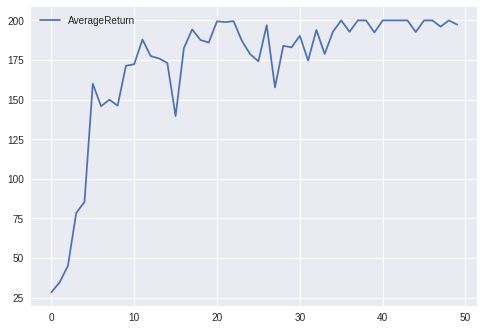

In [12]:
import os.path as osp
import numpy as np
import csv
import matplotlib.pyplot as plt
import json
import joblib
from glob import glob
import os

mypath = '/content/data/local/experiment/experiment_2019_01_07_12_12_32_0001/'

plots = []
legends = []
returns = []
with open(osp.join(mypath, 'progress.csv'), 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['AverageReturn']:
            returns.append(float(row['AverageReturn']))
returns = np.array(returns)
plots.append(plt.plot(returns)[0])
legends.append('AverageReturn')
plt.legend(plots, legends)
plt.show()

**4. Play Videos of your Agent Behavior**

- You can watch how your agent's behavior improves.
- If you haven't update 'mypath' in the code above, you need to update it here.
- (/content/data/local/experiment/experiment_2019_01_1x_xx_xx_xx_000x)

In [0]:
from IPython import display as pythondisplay
# from pyvirtualdisplay import Display

# from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

import imageio

from os import listdir
from os.path import isfile, join

def plot_movie_js(image_array, filename):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    fig.suptitle(filename, fontsize=160)
    # fig.set_xlabel(filename, fontsize=160)
    # fig.xlabel(filename, fontsize=160)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    pythondisplay.display(IPython_display.display_animation(anim))

# mypath = '/content/data/local/experiment/experiment_2019_01_07_09_37_23_0001/
mypath += 'gym_log/'
mp4files = [f for f in listdir(mypath) if f.endswith(".mp4")]
mp4files.sort()


for filename in mp4files:
    vid = imageio.get_reader(join(mypath, filename),  'ffmpeg')
    # print(len(vid))
    # print(vid.get_data(0).shape)

    screenlist = []
    for i in range(len(vid)):
        image = vid.get_data(i)
        screenlist.append(image)
        # fig = plt.figure()
        # fig.suptitle('image #{}'.format(i), fontsize=20)
        # plt.imshow(image)

    plot_movie_js(screenlist, filename)
